<a href="https://colab.research.google.com/github/Mayank-Konduri/Summer2025_Mayank_Prof.Chen_Patricia/blob/main/Mayank_Summer_2025_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Experiment No.1 - Testing for Sequential Linear Separability (SLS)**

**Step 0 - Import Necessary Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt

**Step 1 - Load and Filter MNIST Dataset**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images shape: (17905, 28, 28)
Train labels shape: (17905,)
Unique train labels: [0 3 8]




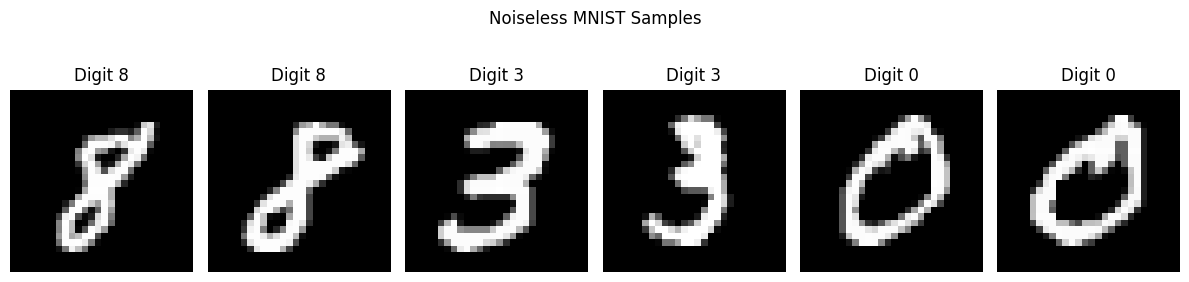

In [ ]:
import tensorflow as tf
import numpy as np

#Load MNIST from TensorFlow
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

#Select classes 0, 3, 8
selected_classes = [8, 3, 0]

#Create filters
train_mask = np.isin(y_train, selected_classes)

#Apply the filter to the training and testing datasets
x_train_subset = x_train[train_mask]
y_train_subset = y_train[train_mask]

print("Train images shape:", x_train_subset.shape)
print("Train labels shape:", y_train_subset.shape)
print("Unique train labels:", np.unique(y_train_subset))
print("")
print("")

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 3))
fig.suptitle("Noiseless MNIST Samples")

plot_idx = 0

for digit in selected_classes:
    indices = np.where(y_train_subset == digit)[0][:2]

    for idx in indices:
        ax = axes[plot_idx]
        ax.imshow(x_train_subset[idx], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Digit {digit}")
        plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [ ]:
#Print to see the number of samples for each digit
unique_labels, counts = np.unique(y_train_subset, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count} samples")

Digit 0: 5923 samples
Digit 3: 6131 samples
Digit 8: 5851 samples


**Step 2 - Flatten Images from MNIST**

In [ ]:
#Flatten each 28x28 image to a 784-dimensional vector
x_train_flat = x_train_subset.reshape(x_train_subset.shape[0], -1)

**Step 3 - Compute Class Means**

In [ ]:
class_means = {}

for label in np.unique(y_train_subset):
    class_images = x_train_flat[y_train_subset == label]

    #Compute mean vector
    mean_vector = np.mean(class_images, axis=0)
    class_means[label] = mean_vector
    print(f"Class {label} mean computed. Shape: {mean_vector.shape}")

Class 0 mean computed. Shape: (784,)
Class 3 mean computed. Shape: (784,)
Class 8 mean computed. Shape: (784,)


**Step 4 - Compute the Barycenter**

In [ ]:
#Combine class mean vectors into a matrix
means_stack = np.stack([class_means[cls] for cls in selected_classes])

#Compute the barycenter as the average of class means
barycenter = np.mean(means_stack, axis=0)

print("Barycenter shape:", barycenter.shape)

Barycenter shape: (784,)


**Step 5 - Determine Class Order**

In [ ]:
selected_classes = [8,3,0]

**Step 6 - Train SVM and Algorithm**

In [ ]:
def sls_experiment(strict=True, error_threshold=0.04):
    #Copies of the training data to modify throughout the experiment
    x_mod = x_train_flat.copy()
    y_mod = y_train_subset.copy()

    #Boolean of whether each class was perfectly separated
    separation_results = {}

    #Number of misclassified points for each class
    misclassified_counts = {}

    #Copy of class means to avoid mutation when collapsed
    class_means_copy = class_means.copy()

    #Collapse point (p_n) for each class
    pn_points = {}

    #Error rate for each class
    error_rate_dict = {}

    #Order of classes
    order = selected_classes # for example [0,3,8]

    for n in order:
        print(f"\nProcessing class {n}...")

        #Exit if only one class remains in the data
        if len(np.unique(y_mod)) == 1:
            print(f"Only class {n} remains — trivially separable.")
            print("")
            print("")
            print("")
            separation_results[n] = True
            misclassified_counts[n] = 0
            error_rate_dict[n] = 0
            break

        #Binary labels: 1 for class n, -1 for all other classes
        y_binary = np.where(y_mod == n, 1, -1)

        #If only one class label exists in y_binary (all 1 or all -1), skip
        # if np.unique(y_binary).size < 2:
        #     print(f"Skipping class {n} — only one class present in binary labels.")
        #     separation_results[n] = True
        #     misclassified_counts[n] = 0
        #     break

        #Training a linear SVM classifier (LinearSVC) to separate class n vs. the rest
        clf = LinearSVC(C=1.0, max_iter=10000)
        #clf = SVC(kernel='linear', C=1e6)
        clf.fit(x_mod, y_binary)

        #Evaluate performance through predictions
        preds = clf.predict(x_mod)

        #Error rate calculation for class n
        error_rate = np.mean(preds[y_binary == 1] != 1)

        #True if no misclassifications
        is_perfect = error_rate == 0.0

        #Results recorded for this class
        separation_results[n] = is_perfect
        misclassified_counts[n] = np.sum(preds != y_binary)
        error_rate_dict[n] = error_rate

        print(f"Perfect separation: {is_perfect}")
        print(f"Misclassified points: {misclassified_counts[n]}")
        print(f"Error rate: {error_rate:.4f}")

        #Condition for moving forward through the order
        if not is_perfect:
            if strict or error_rate > error_threshold:
                print("Stopping due to separation failure.")
                break

        #SVM weight vector
        w = clf.coef_[0]

        #SVM bias
        b = clf.intercept_[0]

        #Mean of the current class
        mean_n = class_means_copy[n]

        #Vector pointing from class mean to barycenter
        direction = barycenter - mean_n

        #Solving for intersection (t)
        t = -(np.dot(w, mean_n) + b) / np.dot(w, direction)

        #Compute p_n using line equation
        p_n = mean_n + t * direction

        #Collapse point storage
        pn_points[n] = p_n

        #Replacing all class-n samples with the single point p_n
        x_mod[y_mod == n] = p_n

        #Removing all class-n entries from the dataset
        keep_mask = y_mod != n
        x_mod = x_mod[keep_mask]
        y_mod = y_mod[keep_mask]

    return separation_results, misclassified_counts, error_rate_dict, error_threshold, pn_points

**Step 7 - Execute Function** (Takes about 10 minutes to execute entirely)


Processing class 8...
Perfect separation: False
Misclassified points: 429
Error rate: 0.0350
Stopping due to separation failure.

Processing class 8...
Perfect separation: False
Misclassified points: 429
Error rate: 0.0350

Processing class 3...
Perfect separation: True
Misclassified points: 0
Error rate: 0.0000

Processing class 0...
Only class 0 remains — trivially separable.





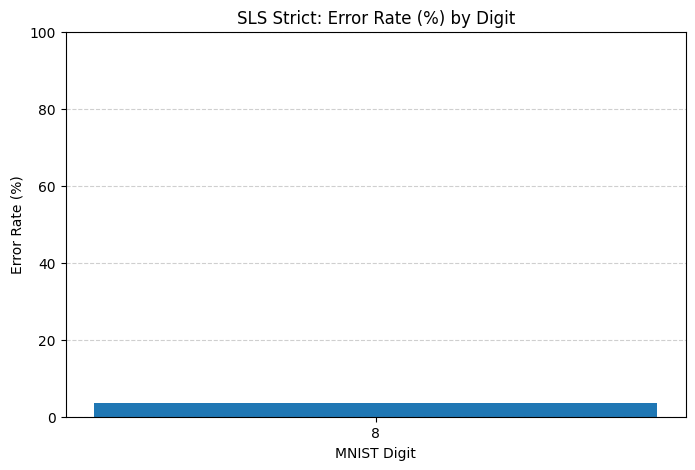

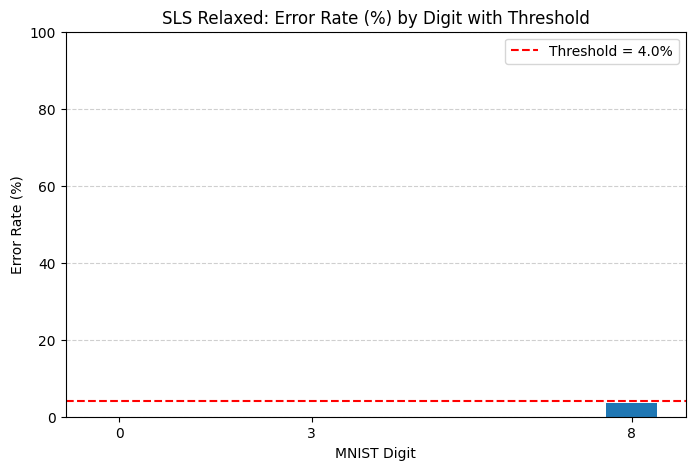

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Run SLS experiments
results_strict, errors_strict, error_rate_dict_strict, _, _ = sls_experiment(strict=True)
results_relaxed, errors_relaxed, error_rate_dict_relaxed, error_threshold, pn_points = sls_experiment(strict=False)

processed_classes_strict = list(error_rate_dict_strict.keys())
errors_strict_pct = [error_rate_dict_strict[d] * 100 for d in processed_classes_strict]

processed_classes_relaxed = list(error_rate_dict_relaxed.keys())
errors_relaxed_pct = [error_rate_dict_relaxed[d] * 100 for d in processed_classes_relaxed]

error_threshold_pct = error_threshold * 100

plt.figure(figsize=(8, 5))
plt.bar(processed_classes_strict, errors_strict_pct, tick_label=processed_classes_strict)
plt.title('SLS Strict: Error Rate (%) by Digit')
plt.xlabel('MNIST Digit')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(processed_classes_relaxed, errors_relaxed_pct, tick_label=processed_classes_relaxed)
plt.axhline(y=error_threshold_pct, color='red', linestyle='--', label=f'Threshold = {error_threshold_pct:.1f}%')
plt.title('SLS Relaxed: Error Rate (%) by Digit with Threshold')
plt.xlabel('MNIST Digit')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# **Behind the Scenes**

> **My visualization of SLS** (Just an example of what I percieved)

<img src="https://drive.google.com/uc?export=view&id=1hxnV_JozTl1NNrSsw755JB-xSaqlhALI" width="500">


> **Calculation of collapse point**

<img src="https://drive.google.com/uc?export=view&id=1A986eSJFXzjIqWnxjKMmZ3_rub5X_JUv" width="500">


# **End of Initial Experiment:** *Additional Experiments with more digits, and digits with gaussian noise follow below...*

* **More digits:** More classes lead to more class boundaries, making separation harder.

* **Gaussian noise:** Noise alters pixel patterns, making true class features less distinguishable.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.svm import LinearSVC

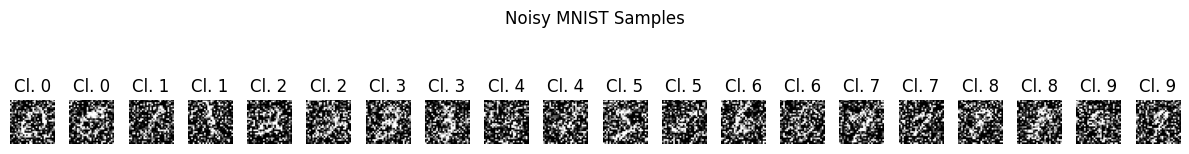

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

#Selecting hard to separate digits
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

mask = np.isin(y_train, selected_classes)
x_selected = x_train[mask]
y_selected = y_train[mask]

#Adding Gaussian noise
noise_level = 0.75
x_noisy = x_selected + noise_level * 255 * np.random.randn(*x_selected.shape)
x_noisy = np.clip(x_noisy, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 20, figsize=(12, 2))
idx = 0
for cls in selected_classes:
    class_indices = np.where(y_selected == cls)[0][:2]
    for i in class_indices:
        axes[idx].imshow(x_noisy[i], cmap='gray')
        axes[idx].set_title(f"Cl. {y_selected[i]}")
        axes[idx].axis('off')
        idx += 1

plt.suptitle("Noisy MNIST Samples")
plt.tight_layout()
plt.show()

In [ ]:
unique_labels, counts = np.unique(y_selected, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count} samples")

Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


In [ ]:
x_train_flat = x_noisy.reshape(x_noisy.shape[0], -1)

In [ ]:
class_means = {}

for label in np.unique(y_selected):
    class_images = x_train_flat[y_selected == label]

    mean_vector = np.mean(class_images, axis=0)
    class_means[label] = mean_vector
    print(f"Class {label} mean computed. Shape: {mean_vector.shape}")

Class 0 mean computed. Shape: (784,)
Class 1 mean computed. Shape: (784,)
Class 2 mean computed. Shape: (784,)
Class 3 mean computed. Shape: (784,)
Class 4 mean computed. Shape: (784,)
Class 5 mean computed. Shape: (784,)
Class 6 mean computed. Shape: (784,)
Class 7 mean computed. Shape: (784,)
Class 8 mean computed. Shape: (784,)
Class 9 mean computed. Shape: (784,)


In [ ]:
means_stack = np.stack([class_means[cls] for cls in selected_classes])

barycenter = np.mean(means_stack, axis=0)

print("Barycenter shape:", barycenter.shape)

Barycenter shape: (784,)


In [ ]:
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
def sls_experiment(strict=True, error_threshold=0.35):
    x_mod = x_train_flat.copy()
    y_mod = y_selected.copy()

    separation_results = {}

    misclassified_counts = {}

    class_means_copy = class_means.copy()

    pn_points = {}

    error_rate_dict = {}

    order = selected_classes

    for n in order:
        print(f"\nProcessing class {n}...")

        if len(np.unique(y_mod)) == 1:
            print(f"Only class {n} remains — trivially separable.")
            print("")
            print("")
            print("")
            separation_results[n] = True
            misclassified_counts[n] = 0
            error_rate_dict[n] = 0
            break

        y_binary = np.where(y_mod == n, 1, -1)

        clf = LinearSVC(C=1.0, max_iter=10000)
        clf.fit(x_mod, y_binary)

        preds = clf.predict(x_mod)

        error_rate = np.mean(preds[y_binary == 1] != 1)

        is_perfect = error_rate == 0.0

        separation_results[n] = is_perfect
        misclassified_counts[n] = np.sum(preds != y_binary)
        error_rate_dict[n] = error_rate

        print(f"Perfect separation: {is_perfect}")
        print(f"Misclassified points: {misclassified_counts[n]}")
        print(f"Error rate: {error_rate:.4f}")

        if not is_perfect:
            if strict or error_rate > error_threshold:
                print("Stopping due to separation failure.")
                break

        w = clf.coef_[0]

        b = clf.intercept_[0]

        mean_n = class_means_copy[n]

        direction = barycenter - mean_n

        t = -(np.dot(w, mean_n) + b) / np.dot(w, direction)

        p_n = mean_n + t * direction

        pn_points[n] = p_n

        x_mod[y_mod == n] = p_n

        keep_mask = y_mod != n
        x_mod = x_mod[keep_mask]
        y_mod = y_mod[keep_mask]

    return separation_results, misclassified_counts, error_rate_dict, error_threshold, pn_points


Processing class 0...
Perfect separation: False
Misclassified points: 1408
Error rate: 0.1552
Stopping due to separation failure.

Processing class 0...
Perfect separation: False
Misclassified points: 1408
Error rate: 0.1552

Processing class 1...
Perfect separation: False
Misclassified points: 1783
Error rate: 0.1517

Processing class 2...
Perfect separation: False
Misclassified points: 2513
Error rate: 0.3075

Processing class 3...
Perfect separation: False
Misclassified points: 2481
Error rate: 0.2750

Processing class 4...
Perfect separation: False
Misclassified points: 2804
Error rate: 0.3367

Processing class 5...
Perfect separation: False
Misclassified points: 2483
Error rate: 0.3029

Processing class 6...
Perfect separation: False
Misclassified points: 549
Error rate: 0.0517

Processing class 7...
Perfect separation: False
Misclassified points: 1442
Error rate: 0.1288

Processing class 8...
Perfect separation: False
Misclassified points: 643
Error rate: 0.0545

Processing clas

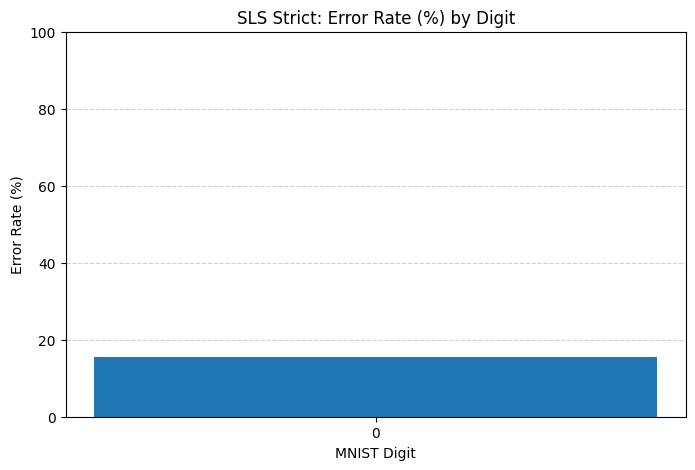

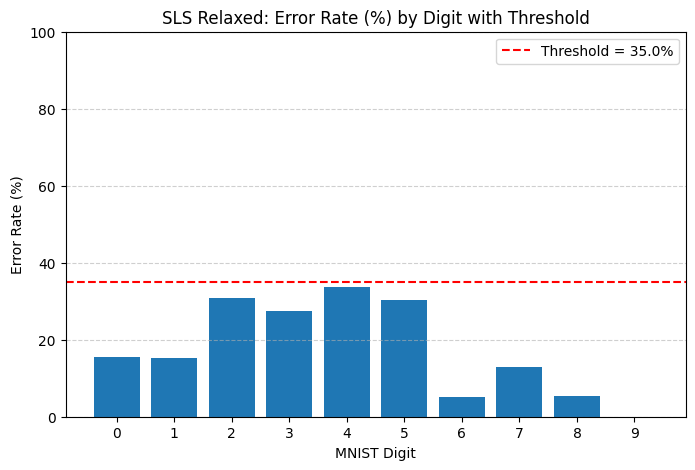

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results_strict, errors_strict, error_rate_dict_strict, _, _ = sls_experiment(strict=True)
results_relaxed, errors_relaxed, error_rate_dict_relaxed, error_threshold, pn_points = sls_experiment(strict=False)

processed_classes_strict = list(error_rate_dict_strict.keys())
errors_strict_pct = [error_rate_dict_strict[d] * 100 for d in processed_classes_strict]

processed_classes_relaxed = list(error_rate_dict_relaxed.keys())
errors_relaxed_pct = [error_rate_dict_relaxed[d] * 100 for d in processed_classes_relaxed]

error_threshold_pct = error_threshold * 100

plt.figure(figsize=(8, 5))
plt.bar(processed_classes_strict, errors_strict_pct, tick_label=processed_classes_strict)
plt.title('SLS Strict: Error Rate (%) by Digit')
plt.xlabel('MNIST Digit')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(processed_classes_relaxed, errors_relaxed_pct, tick_label=processed_classes_relaxed)
plt.axhline(y=error_threshold_pct, color='red', linestyle='--', label=f'Threshold = {error_threshold_pct:.1f}%')
plt.title('SLS Relaxed: Error Rate (%) by Digit with Threshold')
plt.xlabel('MNIST Digit')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()